# Deep Analysis of gRNA Classifier: Error Investigation & RNA Structure

## Scientific Objectives

This notebook performs a rigorous analysis of the XGBoost gRNA classifier to understand:

1. **Error Analysis**: Why does the model misclassify certain sequences?
   - False Positives: Non-gRNA sequences incorrectly classified as gRNA
   - False Negatives: True gRNA sequences missed by the classifier

2. **Feature Importance Discrepancy**: MDI vs Permutation importance comparison
   - Why do different methods rank features differently?
   - Which features truly drive model decisions?

3. **RNA Secondary Structure**: Biological validation using ViennaRNA
   - Do gRNAs show distinct folding properties?
   - Can structure explain classification errors?

### Background

Guide RNAs (gRNAs) in *Trypanosoma brucei* direct the editing of mitochondrial mRNA through 
insertion and deletion of uridines. Functional gRNAs require:
- **Open anchor region**: Must remain single-stranded for Watson-Crick base pairing with target mRNA
- **Structural flexibility**: Stable hairpins would prevent mRNA binding
- **Specific sequence motifs**: Initiation patterns, anchor composition, terminal features

---

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print(f"XGBoost version: {xgb.__version__}")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available - will use RandomForest")

# ViennaRNA for structure prediction
try:
    import RNA
    VIENNARNA_AVAILABLE = True
    print(f"ViennaRNA version: {RNA.__version__}")
except ImportError:
    VIENNARNA_AVAILABLE = False
    print("ViennaRNA not available - structure analysis will be skipped")
    print("Install with: pip install ViennaRNA")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot configuration
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("\n" + "="*60)
print("All imports loaded successfully")
print("="*60)

XGBoost version: 3.1.1
ViennaRNA version: 2.7.1

All imports loaded successfully


In [3]:
# =============================================================================
# DATA LOADING
# =============================================================================

# Define paths - check multiple locations
POSSIBLE_DATA_DIRS = [
    Path.home() / 'projects' / 'grna-inspector' / 'data' / 'processed' / 'v3_pipeline',
    Path('.')
]

DATA_DIR = None
for path in POSSIBLE_DATA_DIRS:
    if (path / 'train_data.csv').exists():
        DATA_DIR = path
        break

if DATA_DIR is None:
    raise FileNotFoundError("Could not find data files. Please check paths.")

print(f"Data directory: {DATA_DIR}")

# Output directory
OUTPUT_DIR = Path('/Users/anna/projects/grna-inspector/data/processed/v3_pipeline')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

# Load datasets
print("\nLoading datasets...")
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

# Load feature names
with open(DATA_DIR / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines() if line.strip()]

print(f"\nDataset sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Test:     {len(test_df):,} samples")
print(f"  Features: {len(feature_names)}")

# Check for sequence column
HAS_SEQUENCE = 'sequence' in test_df.columns
print(f"\nSequence data available: {HAS_SEQUENCE}")

# Class distribution
print(f"\nClass distribution (test):")
print(f"  gRNA (label=1):     {(test_df['label']==1).sum()} ({(test_df['label']==1).mean()*100:.1f}%)")
print(f"  non-gRNA (label=0): {(test_df['label']==0).sum()} ({(test_df['label']==0).mean()*100:.1f}%)")

Data directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline
Output directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline

Loading datasets...

Dataset sizes:
  Training: 1,621 samples
  Test:     348 samples
  Features: 127

Sequence data available: True

Class distribution (test):
  gRNA (label=1):     174 (50.0%)
  non-gRNA (label=0): 174 (50.0%)


In [4]:
# =============================================================================
# MODEL TRAINING
# =============================================================================

print("="*60)
print("MODEL TRAINING")
print("="*60)

# Prepare features and labels
X_train = train_df[feature_names].values
y_train = train_df['label'].values
X_test = test_df[feature_names].values
y_test = test_df['label'].values

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Train XGBoost (or RandomForest fallback)
if XGBOOST_AVAILABLE:
    print("\nTraining XGBoost classifier...")
    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
else:
    print("\nTraining RandomForest classifier...")
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

model.fit(X_train, y_train)
print("Model training complete.")

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\n" + "="*60)
print("MODEL PERFORMANCE ON TEST SET")
print("="*60)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 non-gRNA  gRNA")
print(f"Actual non-gRNA    {tn:4d}    {fp:4d}  (FP: False Positives)")
print(f"Actual gRNA        {fn:4d}    {tp:4d}  (FN: False Negatives)")

print(f"\nError counts:")
print(f"  False Positives (FP): {fp} - non-gRNA misclassified as gRNA")
print(f"  False Negatives (FN): {fn} - gRNA missed by classifier")

MODEL TRAINING

Training data shape: (1621, 127)
Test data shape: (348, 127)

Training XGBoost classifier...
Model training complete.

MODEL PERFORMANCE ON TEST SET

Accuracy:  0.9483 (94.8%)
Precision: 0.9286
Recall:    0.9713
F1 Score:  0.9494
ROC-AUC:   0.9908

Confusion Matrix:
                 Predicted
                 non-gRNA  gRNA
Actual non-gRNA     161      13  (FP: False Positives)
Actual gRNA           5     169  (FN: False Negatives)

Error counts:
  False Positives (FP): 13 - non-gRNA misclassified as gRNA
  False Negatives (FN): 5 - gRNA missed by classifier


In [5]:
# =============================================================================
# ANNOTATE PREDICTIONS
# =============================================================================

# Add predictions to dataframe
test_df['predicted'] = y_pred
test_df['probability'] = y_prob

# Classify each prediction
def get_prediction_type(row):
    """Classify prediction outcome."""
    if row['label'] == 1 and row['predicted'] == 1:
        return 'True Positive'
    elif row['label'] == 0 and row['predicted'] == 0:
        return 'True Negative'
    elif row['label'] == 0 and row['predicted'] == 1:
        return 'False Positive'
    else:
        return 'False Negative'

test_df['prediction_type'] = test_df.apply(get_prediction_type, axis=1)

# Extract subsets for analysis
tp_df = test_df[test_df['prediction_type'] == 'True Positive'].copy()
tn_df = test_df[test_df['prediction_type'] == 'True Negative'].copy()
fp_df = test_df[test_df['prediction_type'] == 'False Positive'].copy()
fn_df = test_df[test_df['prediction_type'] == 'False Negative'].copy()

print("Prediction Type Distribution:")
print("-" * 50)
for ptype in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
    count = (test_df['prediction_type'] == ptype).sum()
    pct = count / len(test_df) * 100
    print(f"  {ptype:<16}: {count:4d} ({pct:5.1f}%)")

Prediction Type Distribution:
--------------------------------------------------
  True Positive   :  169 ( 48.6%)
  True Negative   :  161 ( 46.3%)
  False Positive  :   13 (  3.7%)
  False Negative  :    5 (  1.4%)


---

# Part 1: Error Analysis

## Why Does the Model Make Mistakes?

Understanding classification errors is crucial for:
1. Identifying model limitations
2. Discovering biological edge cases
3. Guiding feature engineering improvements

---

In [6]:
# =============================================================================
# FALSE POSITIVES ANALYSIS
# =============================================================================

print("="*70)
print("FALSE POSITIVES ANALYSIS")
print("Non-gRNA sequences incorrectly classified as gRNA")
print("="*70)

print(f"\nTotal False Positives: {len(fp_df)}")

if len(fp_df) == 0:
    print("No False Positives - perfect specificity!")
else:
    # Source distribution
    if 'source' in fp_df.columns:
        print("\n1. Source Distribution of False Positives:")
        print("-" * 50)
        for source, count in fp_df['source'].value_counts().items():
            pct = count / len(fp_df) * 100
            print(f"   {source}: {count} ({pct:.1f}%)")
        
        print("\n   Interpretation:")
        print("   - 'minicircle': Model confuses intergenic minicircle regions with gRNA")
        print("   - 'chimeric': Random sequence combinations created gRNA-like patterns")
        print("   - 'random': Model may rely too heavily on composition, not specific motifs")
    
    # Confidence analysis
    print("\n2. Model Confidence on False Positives:")
    print("-" * 50)
    print(f"   Probability range: {fp_df['probability'].min():.3f} - {fp_df['probability'].max():.3f}")
    print(f"   Mean probability:  {fp_df['probability'].mean():.3f}")
    print(f"   Median:            {fp_df['probability'].median():.3f}")
    
    high_conf_fp = fp_df[fp_df['probability'] > 0.8]
    print(f"\n   High-confidence errors (prob > 0.8): {len(high_conf_fp)}")
    if len(high_conf_fp) > 0:
        print("   WARNING: These require careful investigation!")

FALSE POSITIVES ANALYSIS
Non-gRNA sequences incorrectly classified as gRNA

Total False Positives: 13

1. Source Distribution of False Positives:
--------------------------------------------------
   random: 7 (53.8%)
   chimeric: 6 (46.2%)

   Interpretation:
   - 'minicircle': Model confuses intergenic minicircle regions with gRNA
   - 'chimeric': Random sequence combinations created gRNA-like patterns
   - 'random': Model may rely too heavily on composition, not specific motifs

2. Model Confidence on False Positives:
--------------------------------------------------
   Probability range: 0.593 - 0.992
   Mean probability:  0.804
   Median:            0.778

   High-confidence errors (prob > 0.8): 6


In [7]:
# =============================================================================
# FEATURE COMPARISON: FP vs TP vs TN
# =============================================================================

print("="*70)
print("FEATURE COMPARISON: Why do FP look like gRNA?")
print("="*70)

# Key biological features to analyze
KEY_FEATURES = [
    # Anchor region (critical for gRNA function)
    'anchor_AC_content', 'anchor_C_freq', 'anchor_G_freq', 'anchor_G_depleted',
    # Initiation patterns
    'init_has_AWAHH', 'init_has_AAAA', 'init_4_A_count', 'init_starts_A',
    # Guiding region
    'guide_A_freq', 'guide_A_elevated', 'guide_purine_freq',
    # Terminal features
    'ends_with_T', 'last3_T_count', 'last5_T_freq',
    # Structural features
    'max_homopolymer', 'complexity_ratio', 'entropy',
    # Composition
    'global_A_freq', 'global_T_freq', 'dinuc_TT_freq', 'dinuc_AC_freq',
    # Signature
    'grna_signature_count'
]

# Filter to available features
available_features = [f for f in KEY_FEATURES if f in feature_names]

print(f"\nAnalyzing {len(available_features)} key biological features:\n")
print(f"{'Feature':<25} {'TP (gRNA)':<12} {'TN (non)':<12} {'FP':<12} {'FP closer to':>15}")
print("-" * 80)

fp_grna_like_features = []
comparison_data = []

for feat in available_features:
    tp_mean = tp_df[feat].mean() if feat in tp_df.columns else np.nan
    tn_mean = tn_df[feat].mean() if feat in tn_df.columns else np.nan
    fp_mean = fp_df[feat].mean() if feat in fp_df.columns and len(fp_df) > 0 else np.nan
    
    if np.isnan(fp_mean) or np.isnan(tp_mean) or np.isnan(tn_mean):
        continue
    
    dist_to_tp = abs(fp_mean - tp_mean)
    dist_to_tn = abs(fp_mean - tn_mean)
    
    if dist_to_tp < dist_to_tn:
        verdict = "gRNA (TP)"
        fp_grna_like_features.append(feat)
    else:
        verdict = "non-gRNA (TN)"
    
    comparison_data.append({
        'feature': feat,
        'TP_mean': tp_mean,
        'TN_mean': tn_mean,
        'FP_mean': fp_mean,
        'FP_closer_to': verdict
    })
    
    print(f"{feat:<25} {tp_mean:<12.4f} {tn_mean:<12.4f} {fp_mean:<12.4f} {verdict:>15}")

comparison_df = pd.DataFrame(comparison_data)

print("-" * 80)
print(f"\nSummary: {len(fp_grna_like_features)}/{len(available_features)} features where FP resemble gRNA")
print(f"\nFeatures where FP look like gRNA:")
for f in fp_grna_like_features:
    print(f"  - {f}")

FEATURE COMPARISON: Why do FP look like gRNA?

Analyzing 22 key biological features:

Feature                   TP (gRNA)    TN (non)     FP              FP closer to
--------------------------------------------------------------------------------
anchor_AC_content         0.7851       0.5489       0.7078             gRNA (TP)
anchor_C_freq             0.2115       0.0655       0.1795             gRNA (TP)
anchor_G_freq             0.0707       0.1531       0.1154         non-gRNA (TN)
anchor_G_depleted         0.8935       0.5466       0.7692             gRNA (TP)
init_has_AWAHH            0.4083       0.0559       0.3077             gRNA (TP)
init_has_AAAA             0.0651       0.0186       0.0769             gRNA (TP)
init_4_A_count            2.6391       1.4907       2.5385             gRNA (TP)
init_starts_A             0.8343       0.3478       0.7692             gRNA (TP)
guide_A_freq              0.4087       0.4016       0.3978         non-gRNA (TN)
guide_A_elevated       

In [8]:
# =============================================================================
# INDIVIDUAL FALSE POSITIVE ANALYSIS
# =============================================================================

if len(fp_df) > 0:
    print("="*70)
    print("DETAILED ANALYSIS OF EACH FALSE POSITIVE")
    print("="*70)
    
    for idx, (_, row) in enumerate(fp_df.iterrows()):
        print(f"\n{'─'*60}")
        print(f"FALSE POSITIVE #{idx+1}")
        print(f"{'─'*60}")
        
        # Basic info
        if 'sequence_id' in row.index:
            print(f"ID: {row['sequence_id']}")
        if 'source' in row.index:
            print(f"Source: {row['source']}")
        print(f"Model probability: {row['probability']:.3f} ({row['probability']*100:.0f}% confident it's gRNA)")
        
        # Sequence
        if HAS_SEQUENCE:
            seq = row['sequence']
            print(f"Sequence length: {len(seq)} nt")
            print(f"Sequence: {seq[:50]}{'...' if len(seq) > 50 else ''}")
        
        # Key features comparison
        print("\nKey feature values (compared to typical gRNA):")
        key_feats = ['anchor_AC_content', 'anchor_C_freq', 'init_4_A_count', 
                     'init_has_AWAHH', 'dinuc_TT_freq', 'grna_signature_count']
        
        grna_like_count = 0
        for feat in key_feats:
            if feat not in row.index:
                continue
            val = row[feat]
            tp_mean = tp_df[feat].mean()
            tn_mean = tn_df[feat].mean()
            
            dist_tp = abs(val - tp_mean)
            dist_tn = abs(val - tn_mean)
            
            if dist_tp < dist_tn:
                verdict = "gRNA-like"
                grna_like_count += 1
            else:
                verdict = "non-gRNA"
            
            print(f"  {feat:<25}: {val:.3f} (TP:{tp_mean:.3f}, TN:{tn_mean:.3f}) -> {verdict}")
        
        print(f"\n  Score: {grna_like_count}/{len(key_feats)} features gRNA-like")
        if grna_like_count >= len(key_feats) // 2:
            print("  CONCLUSION: This sequence genuinely resembles gRNA in multiple features!")

DETAILED ANALYSIS OF EACH FALSE POSITIVE

────────────────────────────────────────────────────────────
FALSE POSITIVE #1
────────────────────────────────────────────────────────────
ID: chimeric_102
Source: chimeric
Model probability: 0.778 (78% confident it's gRNA)
Sequence length: 28 nt
Sequence: TAAATAGAGGTATGTGATAAGTTAGATA

Key feature values (compared to typical gRNA):
  anchor_AC_content        : 0.375 (TP:0.785, TN:0.549) -> non-gRNA
  anchor_C_freq            : 0.000 (TP:0.212, TN:0.065) -> non-gRNA
  init_4_A_count           : 3.000 (TP:2.639, TN:1.491) -> gRNA-like
  init_has_AWAHH           : 0.000 (TP:0.408, TN:0.056) -> non-gRNA
  dinuc_TT_freq            : 0.037 (TP:0.040, TN:0.109) -> gRNA-like
  grna_signature_count     : 3.000 (TP:3.124, TN:1.950) -> gRNA-like

  Score: 3/6 features gRNA-like
  CONCLUSION: This sequence genuinely resembles gRNA in multiple features!

────────────────────────────────────────────────────────────
FALSE POSITIVE #2
────────────────────────

In [9]:
# =============================================================================
# FALSE NEGATIVES ANALYSIS
# =============================================================================

print("="*70)
print("FALSE NEGATIVES ANALYSIS")
print("True gRNA sequences missed by the classifier")
print("="*70)

print(f"\nTotal False Negatives: {len(fn_df)}")

if len(fn_df) == 0:
    print("No False Negatives - perfect sensitivity!")
else:
    # Confidence analysis
    print("\n1. Model Confidence on False Negatives:")
    print("-" * 50)
    print(f"   Probability range: {fn_df['probability'].min():.3f} - {fn_df['probability'].max():.3f}")
    print(f"   Mean probability:  {fn_df['probability'].mean():.3f}")
    print(f"   Note: Low probability means model confidently rejected these as gRNA")
    
    # Compare FN features to typical gRNA
    print("\n2. Feature Comparison: FN vs Typical gRNA (TP):")
    print("-" * 60)
    print(f"{'Feature':<25} {'FN mean':<12} {'TP mean':<12} {'Difference':>12}")
    print("-" * 60)
    
    for feat in ['anchor_AC_content', 'init_has_AWAHH', 'init_4_A_count', 
                 'grna_signature_count', 'ends_with_T']:
        if feat not in fn_df.columns:
            continue
        fn_mean = fn_df[feat].mean()
        tp_mean = tp_df[feat].mean()
        diff = fn_mean - tp_mean
        
        direction = "↓" if diff < -0.05 else "↑" if diff > 0.05 else "≈"
        print(f"{feat:<25} {fn_mean:<12.4f} {tp_mean:<12.4f} {diff:>+11.4f} {direction}")
    
    print("\n   Interpretation:")
    print("   ↓ = FN has LOWER value than typical gRNA (weakened signal)")
    print("   These may be atypical or non-canonical gRNAs")

FALSE NEGATIVES ANALYSIS
True gRNA sequences missed by the classifier

Total False Negatives: 5

1. Model Confidence on False Negatives:
--------------------------------------------------
   Probability range: 0.124 - 0.406
   Mean probability:  0.334
   Note: Low probability means model confidently rejected these as gRNA

2. Feature Comparison: FN vs Typical gRNA (TP):
------------------------------------------------------------
Feature                   FN mean      TP mean        Difference
------------------------------------------------------------
anchor_AC_content         0.4350       0.7851           -0.3501 ↓
init_has_AWAHH            0.2000       0.4083           -0.2083 ↓
init_4_A_count            2.2000       2.6391           -0.4391 ↓
grna_signature_count      1.0000       3.1243           -2.1243 ↓
ends_with_T               0.0000       0.4615           -0.4615 ↓

   Interpretation:
   ↓ = FN has LOWER value than typical gRNA (weakened signal)
   These may be atypical or 

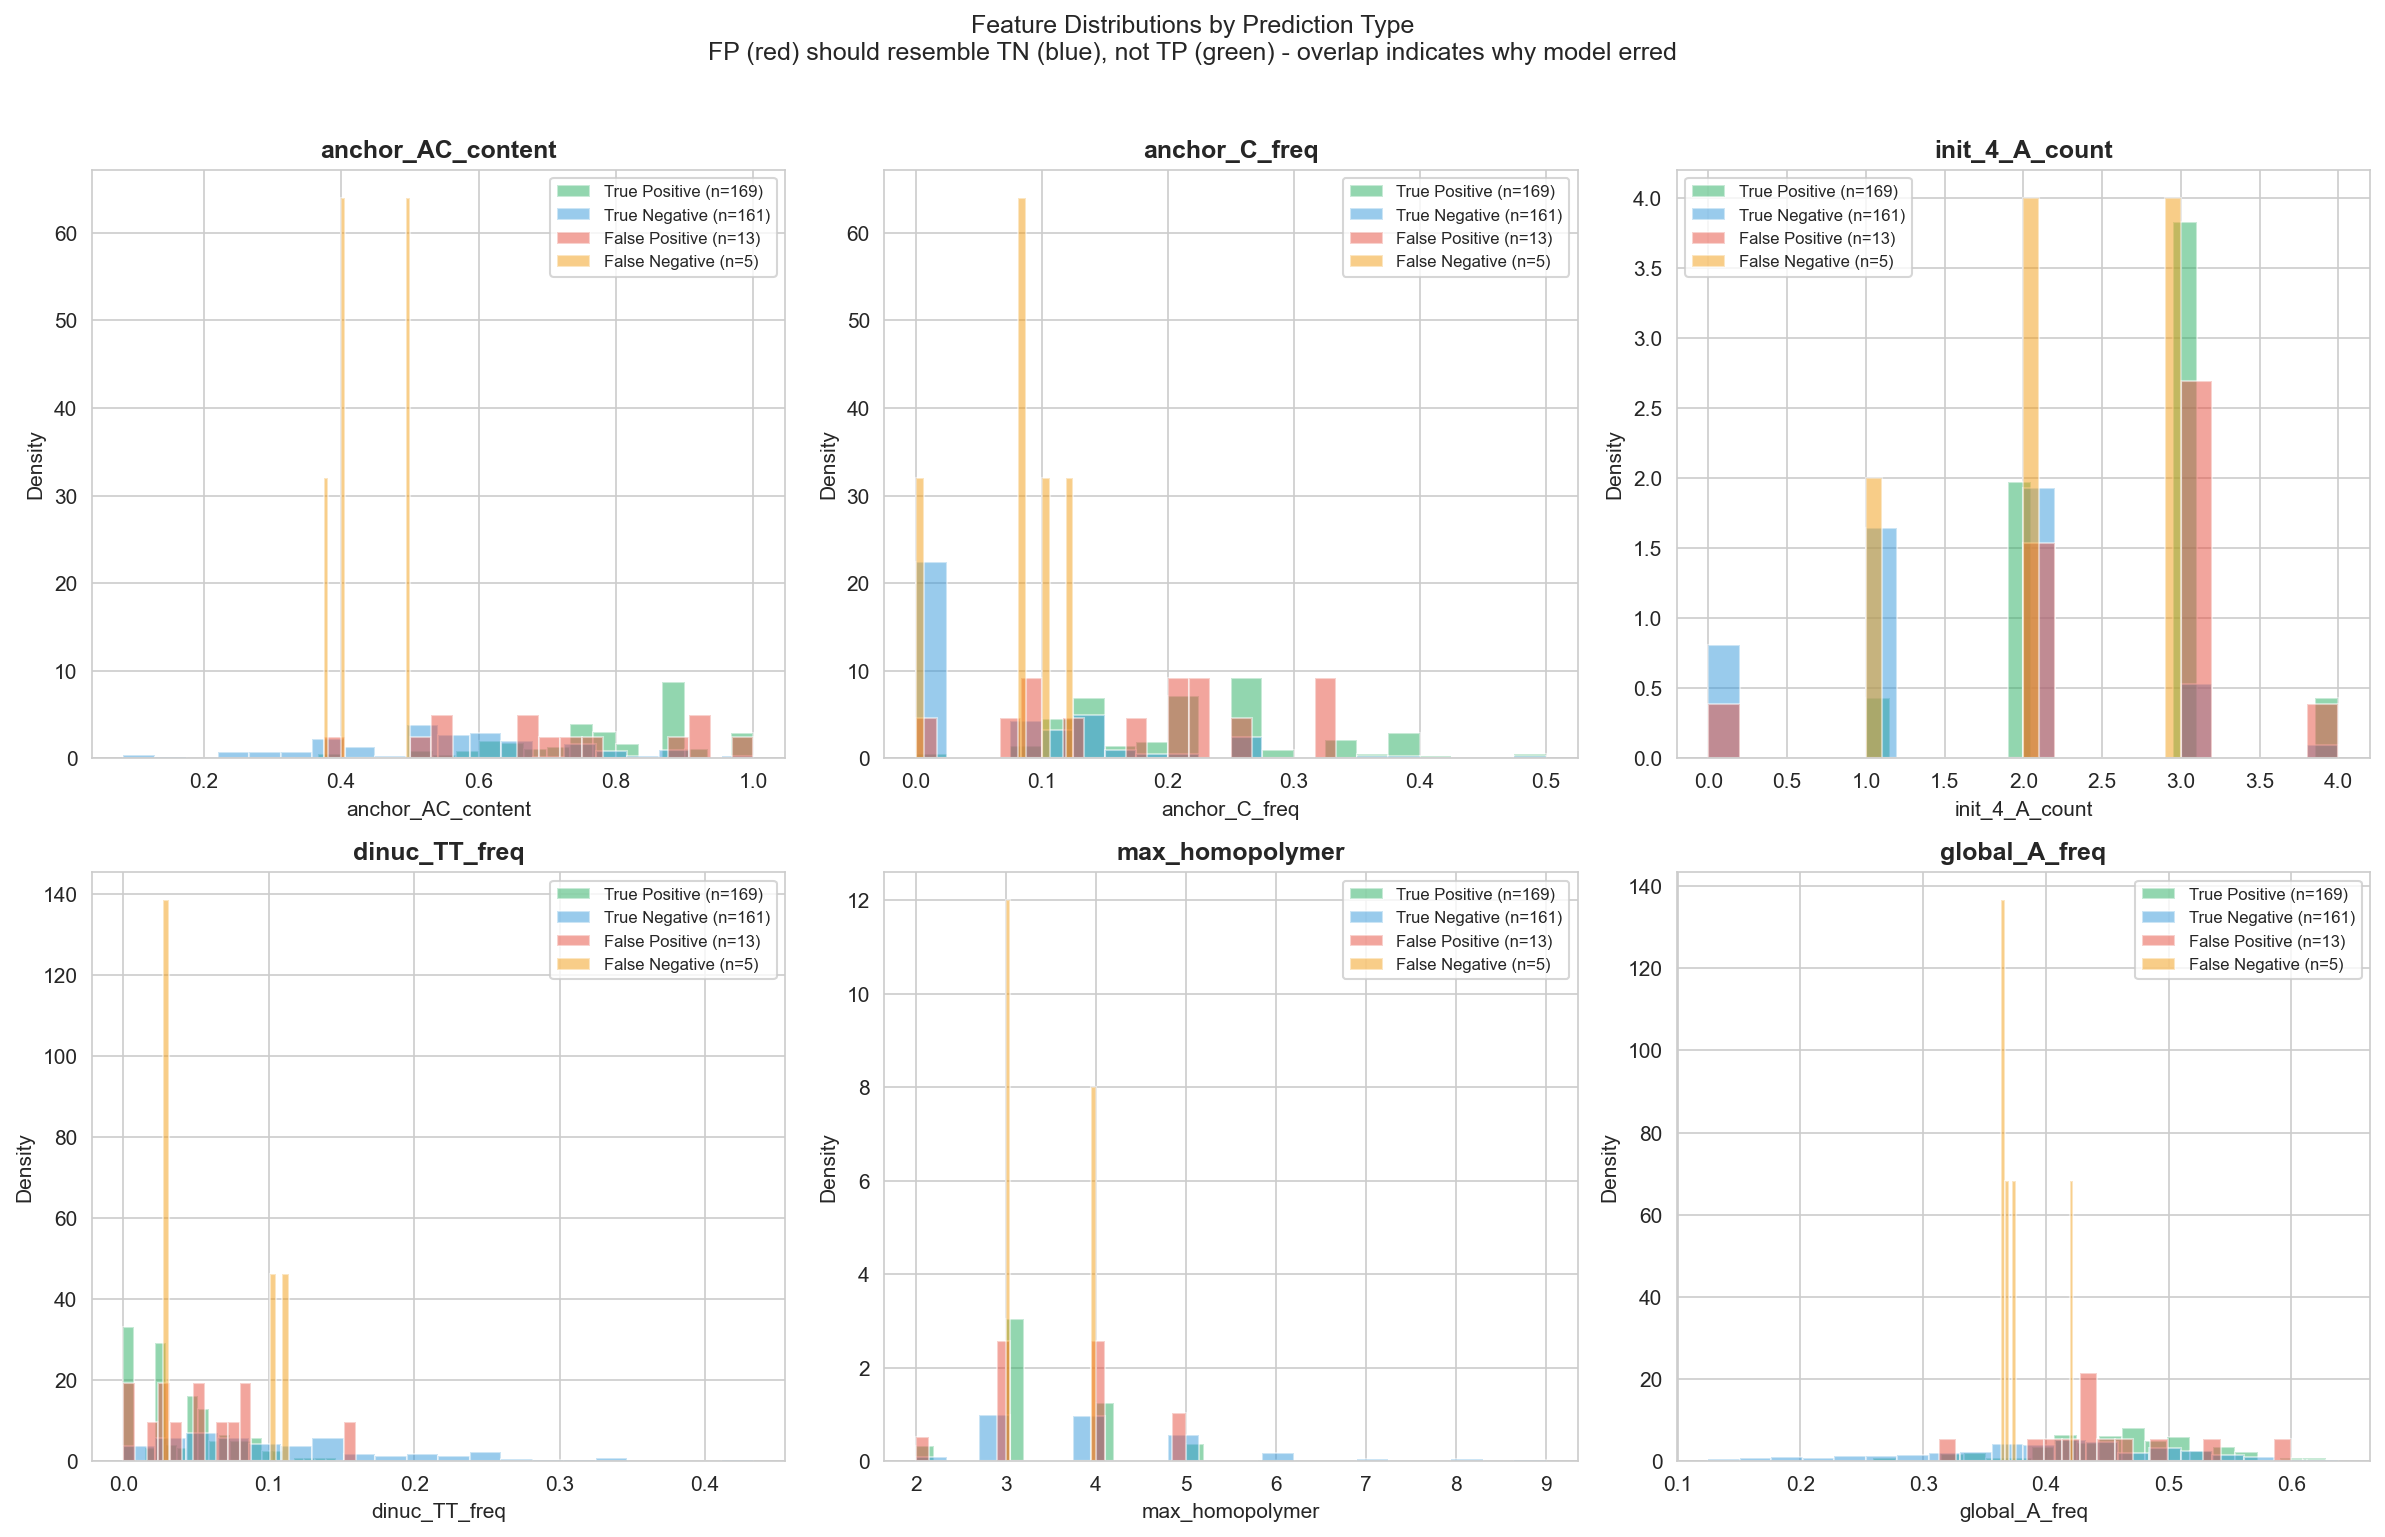

Saved: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/error_feature_distributions.png


In [10]:
# =============================================================================
# VISUALIZATION: Feature Distributions by Prediction Type
# =============================================================================

plot_features = ['anchor_AC_content', 'anchor_C_freq', 'init_4_A_count',
                 'dinuc_TT_freq', 'max_homopolymer', 'global_A_freq']
plot_features = [f for f in plot_features if f in feature_names]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = {
    'True Positive': '#27ae60',   # Green
    'True Negative': '#3498db',   # Blue
    'False Positive': '#e74c3c',  # Red
    'False Negative': '#f39c12'   # Orange
}

for idx, feat in enumerate(plot_features):
    ax = axes[idx]
    
    for ptype in ['True Positive', 'True Negative', 'False Positive', 'False Negative']:
        subset = test_df[test_df['prediction_type'] == ptype]
        if len(subset) > 0 and feat in subset.columns:
            ax.hist(subset[feat], bins=20, alpha=0.5, 
                   label=f"{ptype} (n={len(subset)})",
                   color=colors[ptype], density=True)
    
    ax.set_xlabel(feat, fontsize=10)
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.set_title(feat, fontweight='bold')

# Hide unused axes
for idx in range(len(plot_features), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distributions by Prediction Type\n' +
             'FP (red) should resemble TN (blue), not TP (green) - overlap indicates why model erred',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'error_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR / 'error_feature_distributions.png'}")

---

# Part 2: Feature Importance Analysis

## MDI vs Permutation Importance

Two methods for measuring feature importance can give different results:

- **MDI (Mean Decrease in Impurity)**: How much each feature contributes to splitting decisions
  - Pros: Fast, built into tree-based models
  - Cons: Biased toward high-cardinality features, doesn't measure actual predictive power

- **Permutation Importance**: How much accuracy drops when feature values are shuffled
  - Pros: Model-agnostic, measures actual impact on predictions
  - Cons: Slower, affected by correlated features

---

In [11]:
# =============================================================================
# MDI vs PERMUTATION IMPORTANCE
# =============================================================================

print("="*70)
print("FEATURE IMPORTANCE COMPARISON: MDI vs Permutation")
print("="*70)

# Get MDI importance
if hasattr(model, 'feature_importances_'):
    mdi_importance = model.feature_importances_
else:
    mdi_importance = np.zeros(len(feature_names))

# Calculate permutation importance
print("\nCalculating permutation importance (this may take a moment)...")
perm_result = permutation_importance(
    model, X_test, y_test, 
    n_repeats=10, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
perm_importance = perm_result.importances_mean

# Create comparison dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mdi': mdi_importance,
    'permutation': perm_importance,
    'perm_std': perm_result.importances_std
})

importance_df['mdi_rank'] = importance_df['mdi'].rank(ascending=False).astype(int)
importance_df['perm_rank'] = importance_df['permutation'].rank(ascending=False).astype(int)
importance_df['rank_diff'] = importance_df['mdi_rank'] - importance_df['perm_rank']

# Display comparison
print("\nTop 20 Features by MDI:")
print("-" * 85)
print(f"{'Feature':<30} {'MDI':<10} {'Perm':<10} {'MDI Rank':<10} {'Perm Rank':<10} {'Diff':>8}")
print("-" * 85)

for _, row in importance_df.nlargest(20, 'mdi').iterrows():
    diff = int(row['rank_diff'])
    diff_str = f"{diff:+d}" if diff != 0 else "0"
    print(f"{row['feature']:<30} {row['mdi']:<10.4f} {row['permutation']:<10.4f} "
          f"{int(row['mdi_rank']):<10} {int(row['perm_rank']):<10} {diff_str:>8}")

FEATURE IMPORTANCE COMPARISON: MDI vs Permutation

Calculating permutation importance (this may take a moment)...

Top 20 Features by MDI:
-------------------------------------------------------------------------------------
Feature                        MDI        Perm       MDI Rank   Perm Rank      Diff
-------------------------------------------------------------------------------------
anchor_AC_very_rich            0.3451     0.0000     1          64              -63
anchor_C_freq                  0.0465     0.0040     2          6                -4
anchor_AC_content              0.0417     -0.0023    3          119            -116
init_4_A_count                 0.0362     0.0017     4          13               -9
kmer4_AAAA_present             0.0242     0.0000     5          64              -59
dinuc_AC_freq                  0.0205     -0.0029    6          122            -116
guide_C_count                  0.0183     0.0000     7          64              -57
kmer4_TTTT_presen

In [12]:
# =============================================================================
# FEATURE REGION ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("IMPORTANCE BY gRNA REGION")
print("="*70)

# Categorize features by region
def get_region(feature_name):
    if feature_name.startswith('init_'):
        return 'Initiation'
    elif feature_name.startswith('anchor_'):
        return 'Anchor'
    elif feature_name.startswith('guide_'):
        return 'Guiding'
    elif any(x in feature_name for x in ['ends_', 'last3_', 'last5_']):
        return 'Terminal'
    elif any(x in feature_name for x in ['entropy', 'complexity', 'homopolymer']):
        return 'Structure'
    elif any(x in feature_name for x in ['global_', 'dinuc_', 'kmer']):
        return 'Composition'
    else:
        return 'Other'

importance_df['region'] = importance_df['feature'].apply(get_region)

# Sum importance by region
region_importance = importance_df.groupby('region').agg({
    'mdi': 'sum',
    'permutation': 'sum'
}).round(4)

region_importance['mdi_pct'] = region_importance['mdi'] / region_importance['mdi'].sum() * 100
region_importance['perm_pct'] = region_importance['permutation'] / region_importance['permutation'].sum() * 100

print("\nTotal Importance by gRNA Region:")
print("-" * 60)
print(f"{'Region':<15} {'MDI Sum':<12} {'MDI %':<10} {'Perm Sum':<12} {'Perm %':<10}")
print("-" * 60)

for region in ['Anchor', 'Initiation', 'Guiding', 'Terminal', 'Structure', 'Composition', 'Other']:
    if region in region_importance.index:
        row = region_importance.loc[region]
        print(f"{region:<15} {row['mdi']:<12.4f} {row['mdi_pct']:<10.1f} "
              f"{row['permutation']:<12.4f} {row['perm_pct']:<10.1f}")

print("\nKey Observations:")
print("- Anchor region should dominate (critical for gRNA function)")
print("- Large MDI vs Perm discrepancy suggests correlated features or MDI bias")


IMPORTANCE BY gRNA REGION

Total Importance by gRNA Region:
------------------------------------------------------------
Region          MDI Sum      MDI %      Perm Sum     Perm %    
------------------------------------------------------------
Anchor          0.4723       47.2       -0.0014      -6.2      
Initiation      0.1139       11.4       0.0049       21.8      
Guiding         0.0656       6.6        0.0069       30.7      
Terminal        0.0462       4.6        -0.0060      -26.7     
Structure       0.0315       3.2        0.0075       33.3      
Composition     0.1952       19.5       0.0023       10.2      
Other           0.0752       7.5        0.0083       36.9      

Key Observations:
- Anchor region should dominate (critical for gRNA function)
- Large MDI vs Perm discrepancy suggests correlated features or MDI bias


In [13]:
# =============================================================================
# CORRELATION ANALYSIS OF TOP FEATURES
# =============================================================================

print("\n" + "="*70)
print("CORRELATION ANALYSIS: Are Top Features Redundant?")
print("="*70)

# Get top features from both methods
top_mdi = importance_df.nlargest(15, 'mdi')['feature'].tolist()
top_perm = importance_df.nlargest(15, 'permutation')['feature'].tolist()
top_features = list(set(top_mdi + top_perm))[:20]

# Calculate correlation matrix
corr_matrix = train_df[top_features].corr()

# Find highly correlated pairs
print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
print("-" * 70)

high_corr_pairs = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.7:
            high_corr_pairs.append((top_features[i], top_features[j], corr))

high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

if high_corr_pairs:
    for f1, f2, corr in high_corr_pairs[:10]:
        direction = "positive" if corr > 0 else "negative"
        print(f"   {f1} <-> {f2}")
        print(f"      r = {corr:.3f} ({direction})")
else:
    print("   No highly correlated pairs found.")

print("\nImplication:")
print("   Correlated features share predictive information.")
print("   This explains MDI vs Permutation discrepancy - permutation")
print("   importance is diluted among correlated features.")


CORRELATION ANALYSIS: Are Top Features Redundant?

Highly Correlated Feature Pairs (|r| > 0.7):
----------------------------------------------------------------------
   anchor_AC_very_rich <-> anchor_AC_content
      r = 0.827 (positive)
   anchor_T_freq <-> anchor_AC_content
      r = -0.824 (negative)
   global_A_freq <-> guide_A_freq
      r = 0.806 (positive)
   kmer4_AAAA_present <-> kmer3_AAA_freq
      r = 0.708 (positive)

Implication:
   Correlated features share predictive information.
   This explains MDI vs Permutation discrepancy - permutation
   importance is diluted among correlated features.


In [14]:
# =============================================================================
# INVESTIGATION: dinuc_TT_freq
# =============================================================================

if 'dinuc_TT_freq' in feature_names:
    print("\n" + "="*70)
    print("SPECIAL INVESTIGATION: dinuc_TT_freq")
    print("="*70)
    
    print("""
    This feature often ranks highly in permutation importance.
    
    Biological hypotheses:
    1. Terminal T connection: gRNA end with T for U-tail formation
    2. Poly-T avoidance: gRNA avoid TT runs to stay single-stranded
    3. Sampling artifact: Negative samples may have different TT content
    """)
    
    # Statistical comparison
    grna_tt = train_df[train_df['label'] == 1]['dinuc_TT_freq']
    nongrna_tt = train_df[train_df['label'] == 0]['dinuc_TT_freq']
    
    print("Statistical Comparison:")
    print(f"  gRNA mean:     {grna_tt.mean():.4f} ± {grna_tt.std():.4f}")
    print(f"  non-gRNA mean: {nongrna_tt.mean():.4f} ± {nongrna_tt.std():.4f}")
    print(f"  Difference:    {grna_tt.mean() - nongrna_tt.mean():+.4f}")
    
    t_stat, p_val = stats.ttest_ind(grna_tt, nongrna_tt)
    print(f"  T-test: t={t_stat:.2f}, p={p_val:.2e}")
    
    if grna_tt.mean() < nongrna_tt.mean():
        print("\n  Conclusion: gRNA have LOWER TT frequency")
        print("  This supports hypothesis 2: gRNA avoid poly-T for structural reasons")
    else:
        print("\n  Conclusion: gRNA have HIGHER TT frequency")
        print("  This supports hypothesis 1: related to terminal T features")
    
    # Correlation with terminal features
    print("\nCorrelation with Terminal Features:")
    for feat in ['ends_with_T', 'last5_T_freq', 'last3_T_count']:
        if feat in train_df.columns:
            corr = train_df['dinuc_TT_freq'].corr(train_df[feat])
            print(f"  {feat}: r = {corr:.3f}")


SPECIAL INVESTIGATION: dinuc_TT_freq

    This feature often ranks highly in permutation importance.

    Biological hypotheses:
    1. Terminal T connection: gRNA end with T for U-tail formation
    2. Poly-T avoidance: gRNA avoid TT runs to stay single-stranded
    3. Sampling artifact: Negative samples may have different TT content
    
Statistical Comparison:
  gRNA mean:     0.0368 ± 0.0350
  non-gRNA mean: 0.1114 ± 0.0843
  Difference:    -0.0746
  T-test: t=-23.27, p=1.39e-103

  Conclusion: gRNA have LOWER TT frequency
  This supports hypothesis 2: gRNA avoid poly-T for structural reasons

Correlation with Terminal Features:
  ends_with_T: r = 0.056
  last5_T_freq: r = 0.252
  last3_T_count: r = 0.187


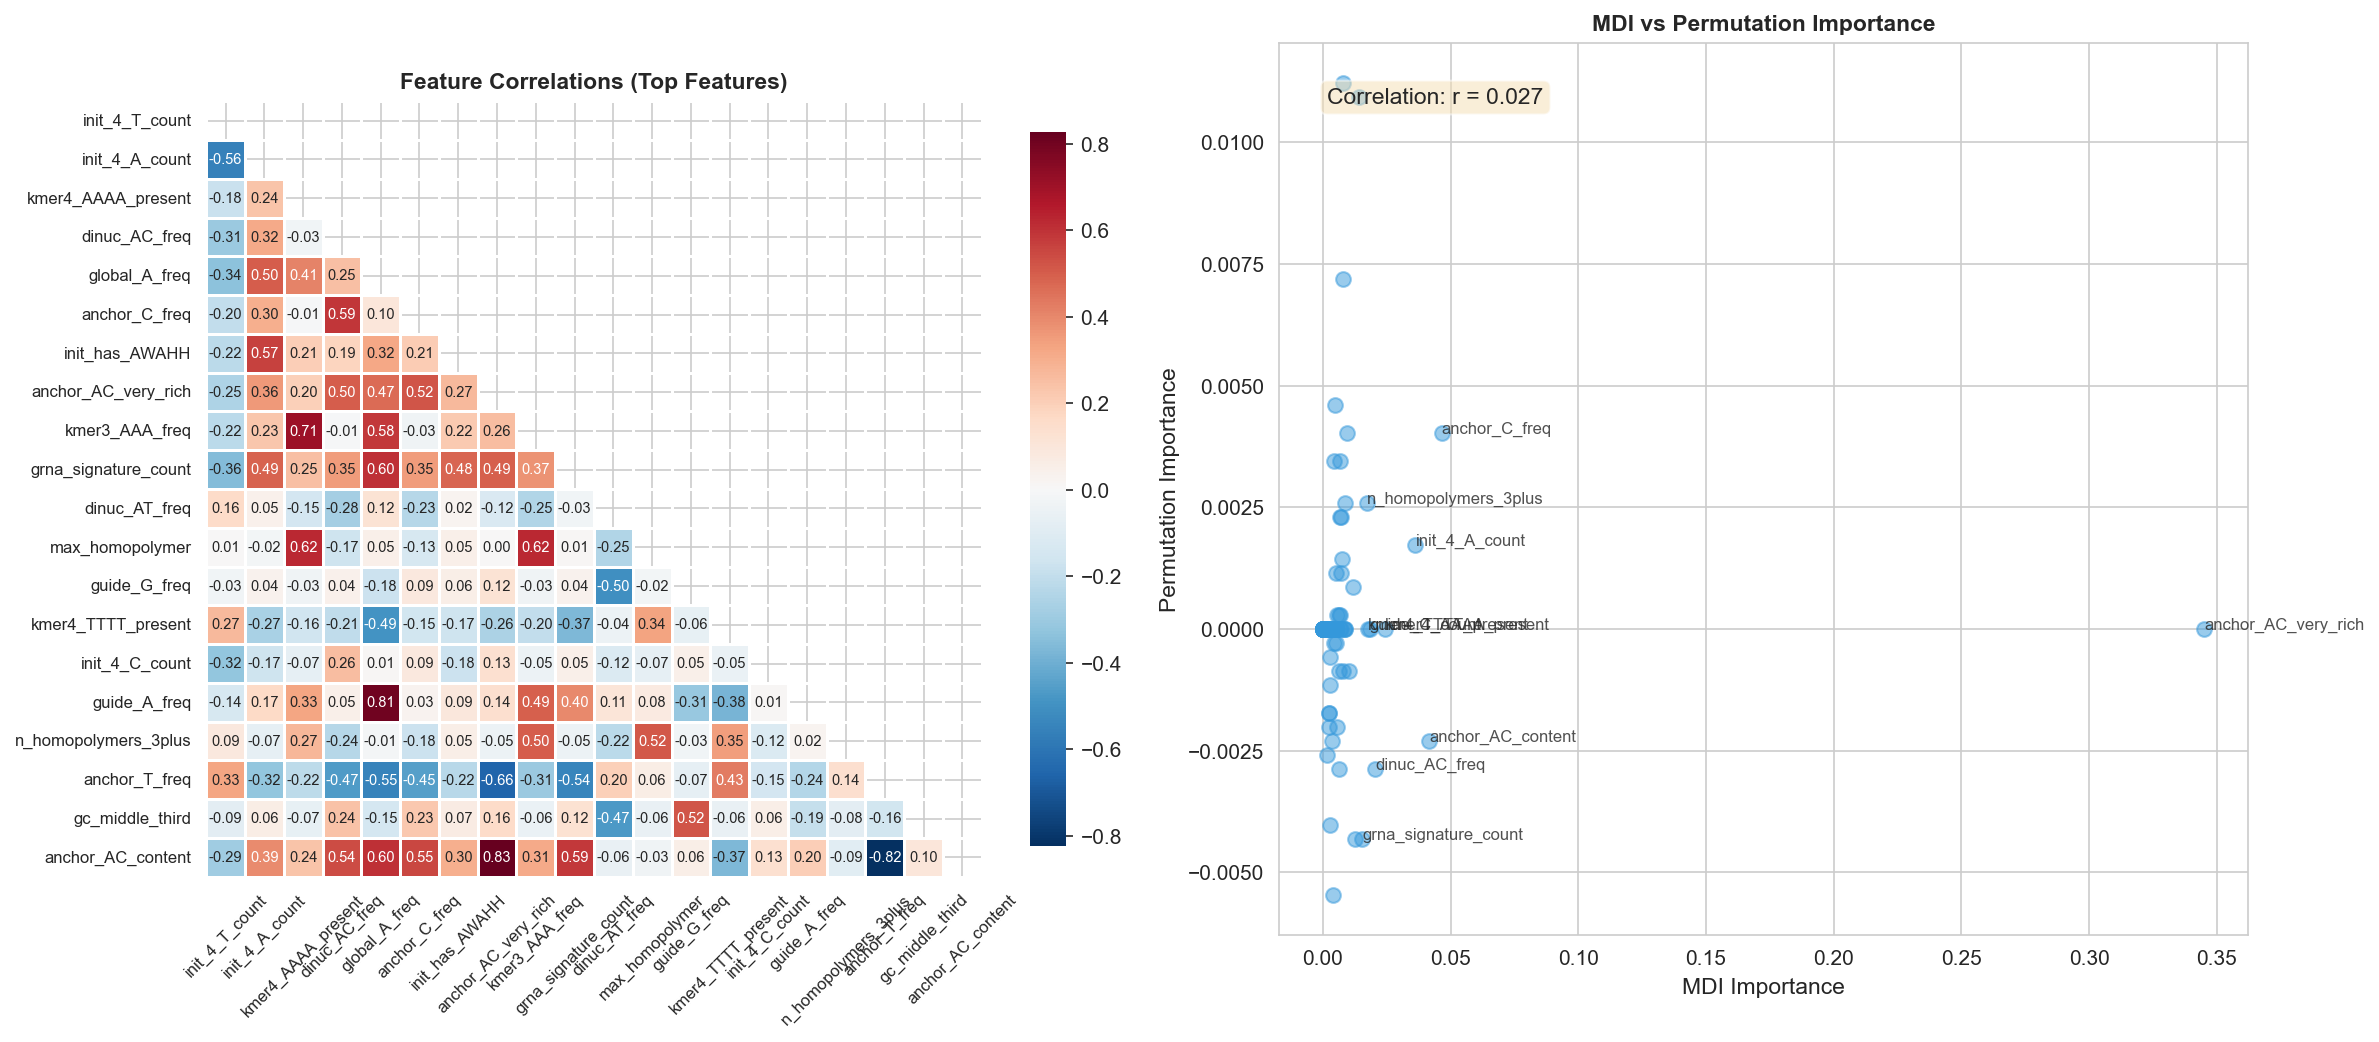


Saved: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/importance_comparison.png


In [15]:
# =============================================================================
# VISUALIZATION: MDI vs Permutation
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Correlation heatmap
ax1 = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            annot=True, fmt='.2f', square=True, ax=ax1,
            annot_kws={'size': 7}, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
ax1.set_title('Feature Correlations (Top Features)', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=8)
ax1.tick_params(axis='y', rotation=0, labelsize=8)

# 2. MDI vs Permutation scatter
ax2 = axes[1]
ax2.scatter(importance_df['mdi'], importance_df['permutation'], 
           alpha=0.5, s=50, c='#3498db')

# Annotate top features
for _, row in importance_df.nlargest(10, 'mdi').iterrows():
    ax2.annotate(row['feature'], (row['mdi'], row['permutation']),
                fontsize=8, alpha=0.8)

ax2.set_xlabel('MDI Importance', fontsize=11)
ax2.set_ylabel('Permutation Importance', fontsize=11)
ax2.set_title('MDI vs Permutation Importance', fontsize=11, fontweight='bold')

# Add correlation
corr_val = np.corrcoef(importance_df['mdi'], importance_df['permutation'])[0, 1]
ax2.text(0.05, 0.95, f'Correlation: r = {corr_val:.3f}', 
        transform=ax2.transAxes, fontsize=11, va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {OUTPUT_DIR / 'importance_comparison.png'}")

In [16]:
# =============================================================================
# SAVE PARTIAL RESULTS
# =============================================================================

print("\nSaving intermediate results...")

# Save error analysis
fp_df.to_csv(OUTPUT_DIR / 'false_positives.csv', index=False)
fn_df.to_csv(OUTPUT_DIR / 'false_negatives.csv', index=False)

# Save importance comparison
importance_df.to_csv(OUTPUT_DIR / 'importance_comparison.csv', index=False)

# Save comparison data
comparison_df.to_csv(OUTPUT_DIR / 'feature_comparison_fp_tp_tn.csv', index=False)

print(f"\nFiles saved to {OUTPUT_DIR}:")
for f in OUTPUT_DIR.glob('*.csv'):
    print(f"  - {f.name}")
for f in OUTPUT_DIR.glob('*.png'):
    print(f"  - {f.name}")


Saving intermediate results...

Files saved to /Users/anna/projects/grna-inspector/data/processed/v3_pipeline:
  - importance_comparison.csv
  - false_negatives.csv
  - feature_comparison_fp_tp_tn.csv
  - false_positives.csv
  - train_data.csv
  - val_data.csv
  - test_data.csv
  - error_feature_distributions.png
  - importance_comparison.png
